In [334]:
import json
from typing import Dict, List, Tuple
from dsp import exact_densest
from dsp import greedy_charikar
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import csv
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [335]:
Edge = Tuple[int, int]
GraphID = str

#Open and load the JSON file
file_path = "twitch_edges.json"
with open(file_path, "r") as f:
    raw_data: Dict[GraphID, List[List[int]]] = json.load(f)

#Convert lists to tuple format for edges
parsed_graphs: Dict[GraphID, List[Edge]] = {
    graph_id: [tuple(edge) for edge in edges]
    for graph_id, edges in raw_data.items()
}



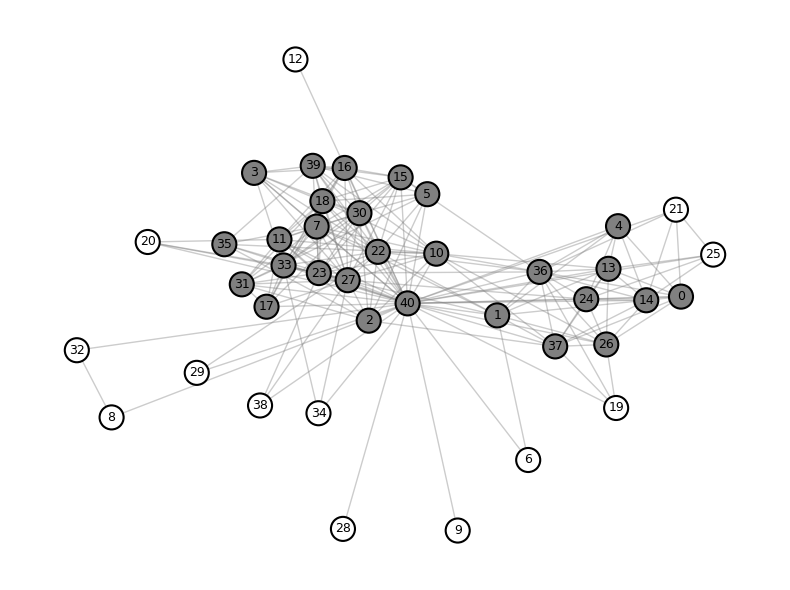

In [346]:
K = 500  # training and testing size
# Load the first 100 graphs 
data_set = dict(list(parsed_graphs.items())[:K])

# Visualize the densest subgraph of a graph with at least 100 edges
graph_iter = iter(data_set.items())

for graph_id, edges in graph_iter:
    if len(edges) >= 200:
        break  # found a graph with at least 100 edges

edges = data_set[graph_id]
# Build the graph
G = nx.Graph()
G.add_edges_from(edges)

# Find the densest subgraph
Sstar, density = exact_densest(G)

# Color nodes: black for densest subgraph, white for others
node_colors = ["black" if node in Sstar else "white" for node in G.nodes()]
edgecolors = ["black"] * len(G.nodes())

# Plot
# Color nodes: gray for densest subgraph, white for others
node_colors = ["gray" if node in Sstar else "white" for node in G.nodes()]
edgecolors = ["black"] * len(G.nodes())

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)

nx.draw_networkx_nodes(
    G, pos,
    node_color=node_colors,
    edgecolors=edgecolors,
    node_size=300,
    linewidths=1.5
)

nx.draw_networkx_edges(G, pos, alpha=0.4, edge_color='gray', width=1.0)

nx.draw_networkx_labels(G, pos, font_size=9, font_color='black')

plt.axis("off")
plt.tight_layout()
plt.show()



In [345]:
# Utility functions
def build_adjacency_list(edges):
    """
    Build an adjacency list from a list of edges.
    """
    adj = defaultdict(set)
    for u, v in edges:
        adj[u].add(v)
        adj[v].add(u)
    return {u: list(neighs) for u, neighs in adj.items()}

def compute_degrees_and_avg_neighbor_degrees(adj_list):
    """
    Compute the degree of each node and the average degree of its neighbors.
    """
    degrees = {node: len(neighbors) for node, neighbors in adj_list.items()}

    avg_neighbor_degrees = {}
    for node, neighbors in adj_list.items():
        if neighbors:
            total = sum(degrees.get(neighbor, 0) for neighbor in neighbors)
            avg = total / len(neighbors)
            avg_neighbor_degrees[node] = avg
        else:
            avg_neighbor_degrees[node] = 0.0

    return degrees, avg_neighbor_degrees

def compute_density(edges, S):
    """
    Compute the density of a subgraph S given the edges of the original graph.
    """
    e_s = 0
    for u, v in edges:
        if u in S and v in S:
            e_s += 1
    return e_s / len(S) if S else 0.0


def augment_ds(edges, S, epsilon = 0.1):
    """
    Our algorithm.
    Augment the densest subgraph from the partial solution S by adding epsilon * |S| / (1 - epsilon) nodes with
    the most number of edges to S.
    """
    t = defaultdict(int)
    for u, v in edges:
        if u not in S and v in S:
            t[u] += 1
        if v not in S and u in S:
            t[v] += 1
    # Sort nodes by their t values
    sorted_nodes = sorted(t.items(), key=lambda x: x[1], reverse=True)
    # Select the top |S| * epsilon / (1 - epsilon) nodes
    num_nodes_to_add = int(len(S) * epsilon / (1 - epsilon))
    nodes_to_add = [node for node, _ in sorted_nodes[:num_nodes_to_add]]
    # Add these nodes to S
    S.update(nodes_to_add)
    # Computer the density of the new S
    num_edges_in_S = 0
    for u, v in edges:
        if u in S and v in S:
            num_edges_in_S += 1
    
    if (len(S) == 0):
        density = 0
    else:
        density = num_edges_in_S / len(S)

    return S, density


In [347]:
# Function to process each graph and write node features to CSV file
def process_graph(graph_id, edges, writer):
    if len(edges) < 100:
        return False

    adj_list = build_adjacency_list(edges)
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj_list)

    # Compute densest subgraph
    H, _ = exact_densest(G)
    H_set = set(H)

    for node in G.nodes():
        writer.writerow([
        degrees.get(node, 0),
        avg_neighbor_degrees.get(node, 0.0),
        len(G),
        int(node in H_set)])
 
    
    return True

graph_iter = iter(data_set.items())
num_graphs = 0
with open("node_features_with_labels.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow([
        "degree",
        "avg_neighbor_degree",
        "number_of_nodes",
        "is_in_densest"
    ])



    for graph_id, edges in tqdm(graph_iter, desc="Processing graphs"):
        if process_graph(graph_id, edges, writer):
            num_graphs += 1

print(f"Number of graphs processed: {num_graphs}")

Processing graphs: 500it [00:18, 27.70it/s]

Number of graphs processed: 275


(11275, 3) (11275,)
              precision    recall  f1-score   support

           0       0.32      0.12      0.17       715
           1       0.68      0.89      0.77      1540

    accuracy                           0.64      2255
   macro avg       0.50      0.50      0.47      2255
weighted avg       0.57      0.64      0.58      2255



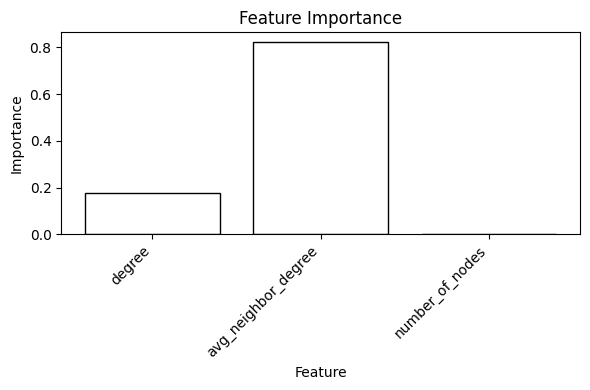

In [348]:
# Load training data from CSV
df = pd.read_csv("node_features_with_labels.csv")
X = df[["degree", "avg_neighbor_degree", "number_of_nodes"]]
y = df["is_in_densest"]

print(X.shape, y.shape)


# Split into train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train a Random Forest
clf = RandomForestClassifier(random_state=42, n_estimators=10)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# Plot feature importance
importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(6, 4))
plt.bar(feature_names, importances, color='white', edgecolor='black')
plt.title("Feature Importance")
plt.ylabel("Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Test size: 253


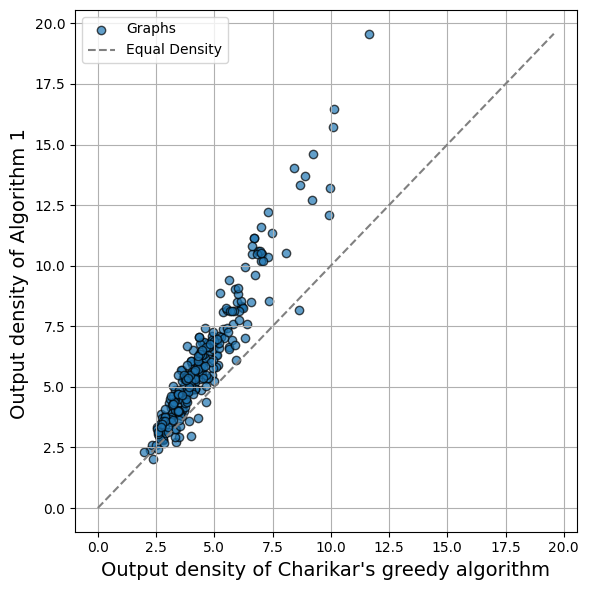

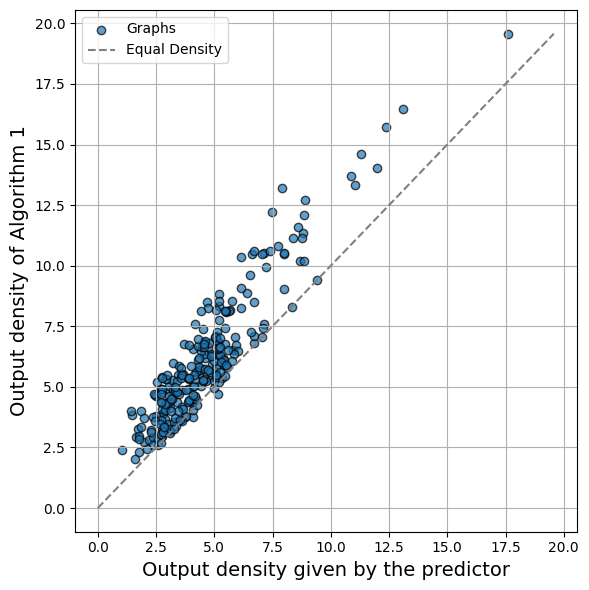

In [350]:
test_data_set = dict(list(parsed_graphs.items())[K:2*K])
graph_iter = iter(test_data_set.items())

augmented_density = []
non_augmented_density = []
peeling_density = []

# Iterate over the graphs for the first 100 graphs
test_size = 0

for graph_id, edges in test_data_set.items():
    if len(edges) < 100:
        continue
    test_size += 1

    adj_list = build_adjacency_list(edges)
    degrees, avg_neighbor_degrees = compute_degrees_and_avg_neighbor_degrees(adj_list)

    G = nx.Graph()
    G.add_edges_from(edges)
    clustering = nx.clustering(G)

    # Prepare features for classifier
    X = pd.DataFrame({
        "degree": [degrees.get(node, 0) for node in adj_list],
        "avg_neighbor_degree": [avg_neighbor_degrees.get(node, 0.0) for node in adj_list],
        "number_of_nodes": [len(adj_list)] * len(adj_list)
    })


    y_pred = clf.predict(X)
    S = {node for node, pred in zip(adj_list.keys(), y_pred) if pred == 1}
    
    # density without augmentation
    density = compute_density(edges, S)
    non_augmented_density.append(density)


    _, aug_density = augment_ds_solution(edges, S, epsilon=0.2)
    augmented_density.append(aug_density)

    _, peel_density = greedy_charikar(G)
    peeling_density.append(peel_density)

print(f"Test size: {test_size}")

plt.figure(figsize=(6, 6))
plt.scatter(peeling_density, augmented_density, label="Graphs", alpha=0.7, edgecolor='black')

# Plot y = x line for reference
max_val = max(max(peeling_density), max(augmented_density))
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='Equal Density')

plt.xlabel("Output density of Charikar's greedy algorithm", fontsize=14)
plt.ylabel("Output density of Algorithm 1 ", fontsize=14)
#plt.title("Augmented Learning Densest Subgraph vs. Charikar's Peeling Algorithm")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 6))
plt.scatter(non_augmented_density, augmented_density, label="Graphs", alpha=0.7, edgecolor='black')

# Plot y = x line for reference
max_val = max(max(non_augmented_density), max(augmented_density))
plt.plot([0, max_val], [0, max_val], color='gray', linestyle='--', label='Equal Density')

plt.xlabel("Output density given by the predictor", fontsize=14)
plt.ylabel("Output density of Algorithm 1", fontsize=14) 
#plt.title("Augmented Learning Densest Subgraph vs. Non-Augmented")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()







In [333]:
# Compute % improvement of augmented over non-augmented
improvement_over_non_aug = [
    100 * (a - n) / n if n > 0 else 0
    for a, n in zip(augmented_density, non_augmented_density)
]

# Compute % improvement of augmented over Charikar peeling
improvement_over_peeling = [
    100 * (a - p) / p if p > 0 else 0
    for a, p in zip(augmented_density, peeling_density)
]

# Compute averages
avg_improvement_non_aug = np.mean(improvement_over_non_aug)
avg_improvement_peeling = np.mean(improvement_over_peeling)

print(f"Average % improvement over non-augmented: {avg_improvement_non_aug:.2f}%")
print(f"Average % improvement over Charikar peeling: {avg_improvement_peeling:.2f}%")

Average % improvement over non-augmented: 47.48%
Average % improvement over Charikar peeling: 31.20%
